### Loading dependencies

In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob

%matplotlib inline

## Camera callibration

### Loading orginal chessboard images

In [2]:
filenames = glob.glob("camera_cal/*.jpg")
#plt.figure(figsize=(13,8))
j = 1
img_raw = []
for i in filenames:
    img = mpimg.imread(i)
    #plt.subplot(5,4,j)
    #plt.imshow(img)
    img_raw.append(img)
    j = j+1

In [3]:
nx = 9
ny = 6
im_shape = img_raw[0].shape
h = im_shape[0]
w = im_shape[1]
#plt.imshow(img_raw[0])
#print(len(img_raw))
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

objpoints = []
imgpoints = []
img_gry = []
for i in range(0,len(img_raw)):
    gry = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_gry.append(gry)
    ret, corners = cv2.findChessboardCorners(gry, (nx,ny), None)
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)
        
ret, cameraMatrix, distortionCoeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, im_shape[:2],None,None)


In [4]:
undistorted = []
#j = 1
#plt.figure(figsize=(13,8))
for i in range(0,len(img_raw)):
    undist = cv2.undistort(img_raw[i], cameraMatrix, distortionCoeffs, None, cameraMatrix)
    undistorted.append(undist)
    #plt.subplot(5,4,j)
    #plt.imshow(img_undist[i])
    #j= j+1

Text(0.5,1,'Undistorted image')

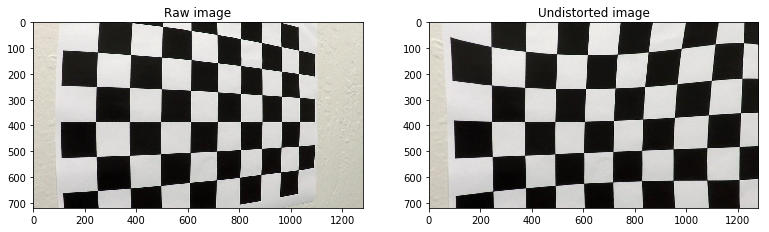

In [5]:
plt.figure(figsize = (13,8))
plt.subplot(1,2,1)
plt.imshow(img_raw[0])
plt.title('Raw image')
plt.subplot(1,2,2)
plt.imshow(undistorted[0])
plt.title('Undistorted image')

## Image processing pipeline

### Undistorting example images

In [6]:
filenames = glob.glob("test_images/*.jpg")
img_tst = []
for i in filenames:
    img = mpimg.imread(i)
    img_tst.append(img)
    
#plt.figure(figsize=(13,26))   
img_undist = []
for i in range(len(img_tst)):
    #plt.subplot(len(img_tst),2,(2*i)+1)
    #plt.imshow(img_tst[i])
    img = cv2.undistort(img_tst[i], cameraMatrix, distortionCoeffs, None, cameraMatrix)
    img_undist.append(img)
    #plt.subplot(len(img_tst),2,(2*i)+2)
    #plt.imshow(img_undist[i])

Text(0.5,1,'Undistorted image')

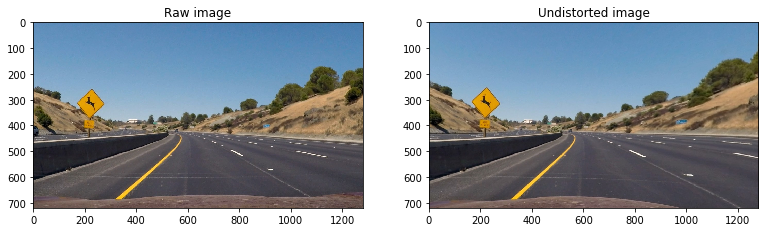

In [7]:
plt.figure(figsize = (13, 8))
plt.subplot(1,2,1)
plt.imshow(img_tst[5])
plt.title('Raw image')
plt.subplot(1,2,2)
plt.imshow(img_undist[5])
plt.title('Undistorted image')

### Defining required function

In [8]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    #img = np.array(img, dtype=np.uint8)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Apply x or y gradient with the OpenCV Sobel() function and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
        
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    # Return the result
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    '''
    Define a function to threshold an image for a given range and Sobel kernel
    '''
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

### Image binarization 

In [9]:
img_thresh = []
for i in img_undist:
    # Apply gradient threshold on the horizontal gradient
    grad_x = abs_sobel_thresh(i, 'x', 10, 210)
    # Thresholding the image based on the given direciton
    img_dir = dir_threshold(i, sobel_kernel=15, thresh=(0.3, 1.5))
    # combine the gradient and direction thresholds.
    combined_condition = ((grad_x == 1) & (img_dir == 1))
    # R & G thresholds so that yellow lanes are detected well.
    color_threshold = 150
    R = i[:,:,0]
    G = i[:,:,1]
    color_combined = np.zeros_like(R)
    r_g_condition = (R > color_threshold) & (G > color_threshold)
    # color channel thresholds
    hls = cv2.cvtColor(i, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    L = hls[:,:,1]
    
    # S channel performs well for detecting bright yellow and white lanes
    s_thresh = (100, 255)
    s_condition = (S > s_thresh[0]) & (S <= s_thresh[1])
    
    # A threshold on the L channel to avoid pixels which have shadows and as a result darker.
    l_thresh = (120, 255)
    l_condition = (L > l_thresh[0]) & (L <= l_thresh[1])

    # combine all the thresholds
    # A pixel should either be a yellowish or whiteish
    # And it should also have a gradient, as per our thresholds
    color_combined[(r_g_condition & l_condition) & (s_condition | combined_condition)] = 1
    
    # apply the region of interest mask
    mask = np.zeros_like(color_combined)
    region_of_interest_vertices = np.array([[0,h-1], [w/2, int(0.5*h)], [w-1, h-1]], dtype=np.int32)
    cv2.fillPoly(mask, [region_of_interest_vertices], 1)
    thresholded = cv2.bitwise_and(color_combined, mask)
    
    img_thresh.append(thresholded)

Text(0.5,1,'Thresholded image')

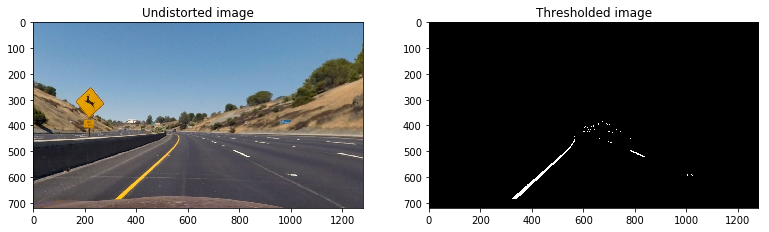

In [10]:
'''j = 1
plt.figure(figsize=(13,26))
for i in range(len(img_thresh)):
    plt.subplot(len(img_thresh),2,(2*i)+1)
    plt.imshow(img_undist[i])
    plt.subplot(len(img_thresh),2,2*i+2)
    plt.imshow(img_thresh[i], cmap='gray')'''
plt.figure(figsize = (13,8))
plt.subplot(1,2,1)
plt.imshow(img_undist[5])
plt.title('Undistorted image')
plt.subplot(1,2,2)
plt.imshow(img_thresh[5], cmap = 'gray')
plt.title('Thresholded image')

Perspective Transform After manually examining a sample image, I extracted the vertices to perform a perspective transform. The polygon with these vertices is drawn on the image for visualization. Destination points are chosen such that straight lanes appear more or less parallel in the transformed image. The transform and its inverse are computer, for use later. We then transform the binary image to show the birds eye view.

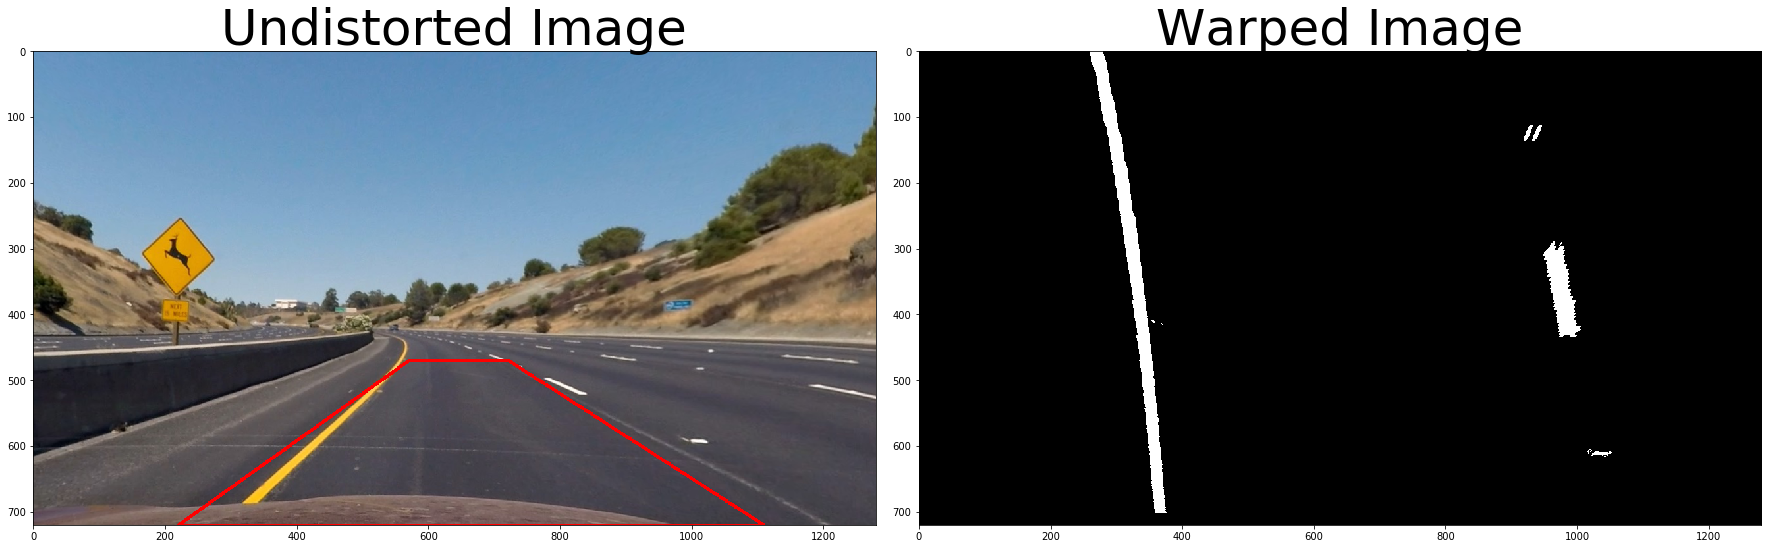

In [11]:
# Vertices extracted manually for performing a perspective transform
bottom_left = [220,720]
bottom_right = [1110, 720]
top_left = [570, 470]
top_right = [722, 470]

source = np.float32([bottom_left,bottom_right,top_right,top_left])

pts = np.array([bottom_left,bottom_right,top_right,top_left], np.int32)
pts = pts.reshape((-1,1,2))
copy = img_undist[5].copy()
cv2.polylines(copy,[pts],True,(255,0,0), thickness=3)

# Destination points are chosen such that straight lanes appear more or less parallel in the transformed image.
bottom_left = [320,720]
bottom_right = [920, 720]
top_left = [320, 1]
top_right = [920, 1]

dst = np.float32([bottom_left,bottom_right,top_right,top_left])
#source = np.float32([[560, 465], [712, 465], [220, 670], [1030, 670]])
#dst = np.float32([[170, 0], [1030, 0], [170, 650], [1030, 650]])
#source = np.float32([[585, 460], [203, 720], [1127, 720], [695, 460]])
#dst = np.float32([[320, 0], [320, 720], [960, 720], [960, 0]])
M = cv2.getPerspectiveTransform(source, dst)
M_inv = cv2.getPerspectiveTransform(dst, source)

image_shape = img_undist[5].shape
img_size = (image_shape[1], image_shape[0])

img_warped = cv2.warpPerspective(img_thresh[5], M, img_size , flags=cv2.INTER_LINEAR)
    
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(copy)
ax1.set_title('Undistorted Image', fontsize=50)
ax2.imshow(img_warped, cmap='gray')
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Perspective transform
### Defining required functions

In [12]:
def warper(img_thresh):
    shape = img_thresh.shape
    img_size = (shape[1],shape[0])
    #src = np.float32([[200,680], [1200, 680], [530, 470], [760, 470]])
    #dst = np.float32([[320,720], [920, 720], [320, 1], [920, 1]])
    #src = np.float32([[560, 465], [712, 465], [220, 670], [1030, 670]])
    #dst = np.float32([[170, 0], [1030, 0], [170, 650], [1030, 650]])
    src = np.float32([[585, 460], [203, 720], [1127, 720], [695, 460]])
    dst = np.float32([[320, 0], [320, 720], [960, 720], [960, 0]])


    # use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img_thresh, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, Minv

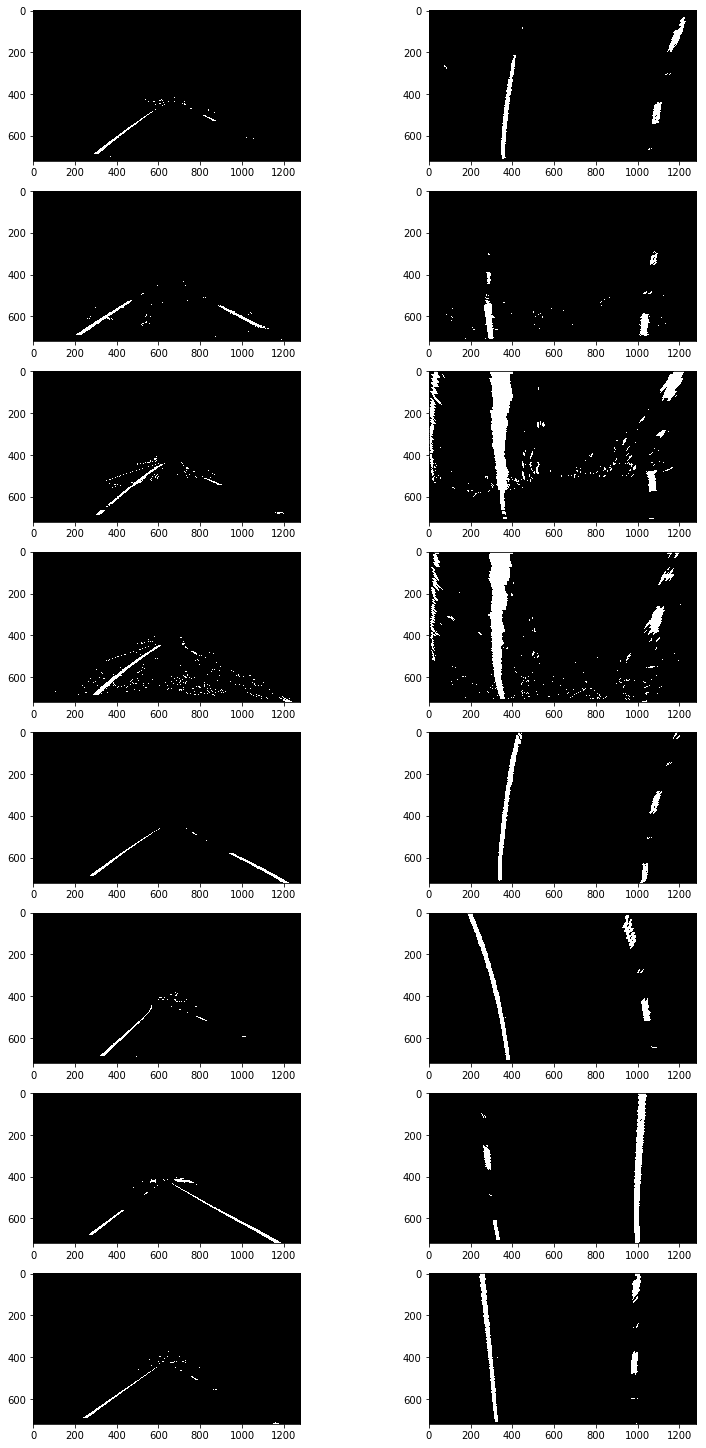

In [13]:
plt.figure(figsize=(13,26))
img_box = []
img_warped = []
Minv = []
for i in range(len(img_thresh)):
    i = np.array(i)
    warped, minv= warper(img_thresh[i])
    #img_box.append(box)
    img_warped.append(warped)
    plt.subplot(len(img_thresh),2,(2*i)+1)
    plt.imshow(img_thresh[i], cmap = 'gray')
    plt.subplot(len(img_thresh),2,(2*i)+2)
    plt.imshow(img_warped[i], cmap = "gray")
    Minv.append(minv)

Text(0.5,1,'Warped binary image')

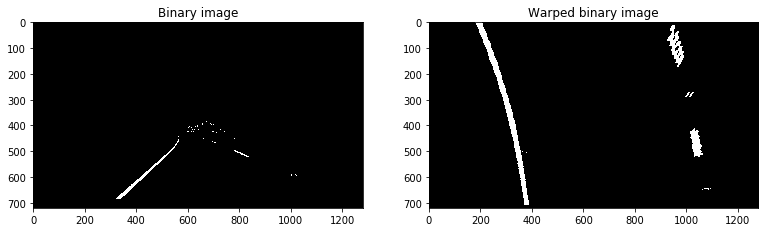

In [14]:
plt.figure(figsize=(13,26))
warped, minv= warper(img_thresh[5])
plt.subplot(1,2,1)
plt.imshow(img_thresh[5], cmap = 'gray')
plt.title('Binary image')
plt.subplot(1,2,2)
plt.imshow(warped, cmap = 'gray')
plt.title('Warped binary image')

## Lane finding

In [15]:
def laneFinder(img_warped):
    img_warped = np.array(img_warped)
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img_warped[int(img_warped.shape[0]/2):, :], axis=0)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((img_warped, img_warped, img_warped)) * 255
    window_img = np.zeros_like(out_img)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0] / 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 10
    
    # Set height of windows
    window_height = np.int(img_warped.shape[0] / nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    rectangle_search = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img_warped.shape[0] - (window + 1) * window_height
        win_y_high = img_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
       
        # Searching boundry
        rectangle_search.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]

    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, img_warped.shape[0] - 1, img_warped.shape[0])
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [100, 200, 255]

    return out_img, rectangle_search, ploty, left_fitx, right_fitx, left_lane_inds, right_lane_inds, margin, window_img, leftx, rightx

In [16]:
out_img, rectangle_search, ploty, left_fitx, right_fitx, left_lane_inds, right_lane_inds, margin, window_img, leftx, rightx = laneFinder(img_warped[0])

(720, 0)

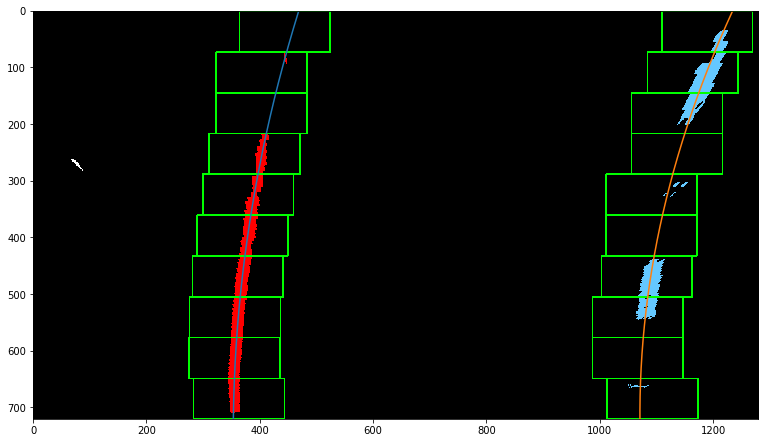

In [17]:
for rect in rectangle_search:
# Draw the windows on the visualization image
    cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 
    cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2) 
# Identify the x and y positions of all nonzero pixels in the image
plt.figure(figsize = (13,8))
plt.imshow(out_img)
plt.plot(left_fitx, ploty)
plt.plot(right_fitx, ploty)
plt.xlim(0, 1280)
plt.ylim(720, 0)

<Figure size 936x1440 with 0 Axes>

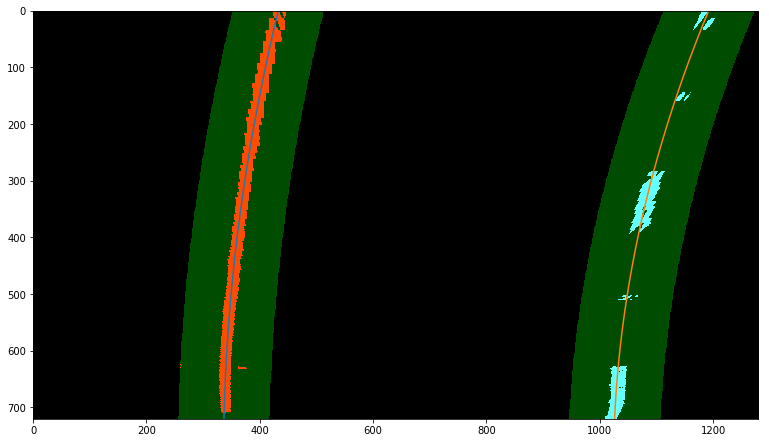

In [18]:
plt.figure(figsize = (13,20))
k = 1
want = []
img_lane = []
for i in range(len(img_warped)):
    out_img, rectangle_search, ploty, left_fitx, right_fitx, left_lane_inds, right_lane_inds, margin, window_img, leftx, rightx = \
    laneFinder(img_warped[i])
    
    want = out_img.copy()
    
    y_points = np.linspace(0,img_warped[i].shape[0]-1,img_warped[i].shape[0])
    
    left_line_window1 = np.array(np.transpose(np.vstack([left_fitx - margin, y_points])))
    left_line_window2 = np.array(np.flipud(np.transpose(np.vstack([left_fitx + margin, y_points]))))
    left_line_points = np.vstack((left_line_window1, left_line_window2))
    cv2.fillPoly(out_img,np.int_([left_line_points]), [0,255, 0])
    
    right_line_window1 = np.array(np.transpose(np.vstack([right_fitx - margin, y_points])))
    right_line_window2 = np.array(np.flipud(np.transpose(np.vstack([right_fitx + margin, y_points]))))
    right_line_points = np.vstack((right_line_window1, right_line_window2))
    cv2.fillPoly(out_img,np.int_([right_line_points]), [0,255, 0])
    
    imglane = cv2.addWeighted(want, 1, out_img, .3, 0)
    img_lane.append(imglane)
    
    if k == 5:
        plt.figure(figsize = (13,20))
        plt.imshow(imglane, cmap = 'gray')
        plt.plot(left_fitx, ploty)
        plt.plot(right_fitx, ploty)
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    k = k +1
    

## Calculating the curve

In [19]:
def curveFinder(ploty, left_fit, right_fit,out_img):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 27 / 720  # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700  # meters per pixel in x dimension
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fit*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fit*xm_per_pix, 2)

    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    curve_rad = (left_curverad+right_curverad)/2
    
    # Lane center
    cntLine = (left_fit_cr[-1]+right_fit_cr[-1])/2
    center_offset = abs((out_img.shape[1]*xm_per_pix/2) - cntLine)
    
    return curve_rad, center_offset
   

In [20]:
img_warped[5].shape

(720, 1280)

In [21]:
def outputMaker(warped,ploty,left_fitx,right_fitx, Minv,image,undist):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

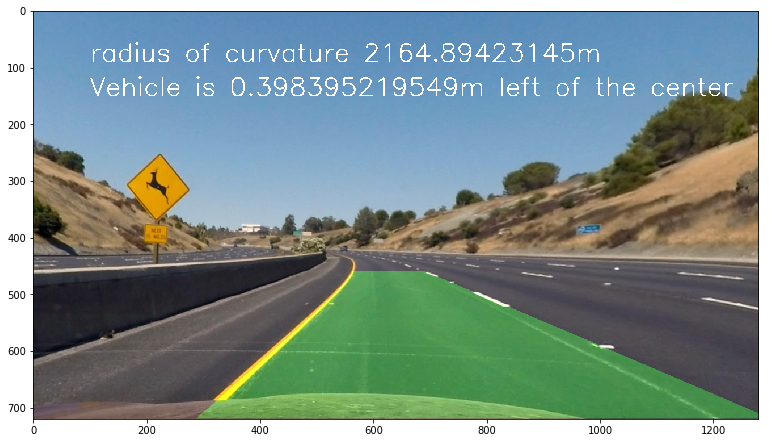

In [22]:
out_img, rectangle_search, ploty, left_fitx, right_fitx, left_lane_inds, right_lane_inds, margin, window_img, leftx, rightx = laneFinder(img_warped[5])
curve_rad,ocenter_offset=curveFinder(ploty, left_fitx, right_fitx,out_img)
curve_rad = 'radius of curvature ' + str(curve_rad) + 'm'
ocenter_offset = 'Vehicle is '+str(ocenter_offset)+'m left of the center'
out = outputMaker(img_warped[5],ploty, left_fitx,right_fitx, Minv[5],img_tst[5],img_undist[5])
cv2.putText(out,curve_rad , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
cv2.putText(out, ocenter_offset, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
plt.figure(figsize = (13,8))
plt.subplot()
plt.imshow(out)

In [23]:
out_img, rectangle_search, ploty, left_fitx, right_fitx, left_lane_inds, right_lane_inds, margin, window_img, leftx, rightx = laneFinder(img_warped[5])
curveFinder(ploty, left_fitx, right_fitx,out_img)

(2164.8942314469082, 0.39839521954939228)

### Defining the pipeline for processing the video

In [24]:
def Arash_pipeline(img_tst):
    # Undistorting
    Minv = []
    #img_tst = 
    img = cv2.undistort(img_tst, cameraMatrix, distortionCoeffs, None, cameraMatrix)
    
    # Thresholing
    # Apply gradient threshold on the horizontal gradient
    grad_x = abs_sobel_thresh(img, 'x', 10, 210)
    # Thresholding the image based on the given direciton
    img_dir = dir_threshold(img, sobel_kernel=15, thresh=(0.3, 1.5))
    # combine the gradient and direction thresholds.
    combined_condition = ((grad_x == 1) & (img_dir == 1))
    # R & G thresholds so that yellow lanes are detected well.
    color_threshold = 150
    R = img[:,:,0]
    G = img[:,:,1]
    color_combined = np.zeros_like(R)
    r_g_condition = (R > color_threshold) & (G > color_threshold)
    # color channel thresholds
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    L = hls[:,:,1]
    # S channel performs well for detecting bright yellow and white lanes
    s_thresh = (100, 255)
    s_condition = (S > s_thresh[0]) & (S <= s_thresh[1])
    # We put a threshold on the L channel to avoid pixels which have shadows and as a result darker.
    l_thresh = (120, 255)
    l_condition = (L > l_thresh[0]) & (L <= l_thresh[1])
    # combine all the thresholds: A pixel should either be a yellowish or whiteish, and it should also have a gradient, as per our thresholds
    color_combined[(r_g_condition & l_condition) & (s_condition | combined_condition)] = 1
    # apply the region of interest mask
    mask = np.zeros_like(color_combined)
    region_of_interest_vertices = np.array([[0,h-1], [w/2, int(0.5*h)], [w-1, h-1]], dtype=np.int32)
    cv2.fillPoly(mask, [region_of_interest_vertices], 1)
    img_thresh = cv2.bitwise_and(color_combined, mask)
    
    # warping
    img_warped, Minv = warper(img_thresh)
    
    # Lane finding
    out_img, rectangle_search, ploty, left_fitx, right_fitx, left_lane_inds, right_lane_inds, margin, window_img, leftx, rightx = laneFinder(img_warped)
    want = out_img.copy()
    
    y_points = np.linspace(0,img_warped.shape[0]-1,img_warped.shape[0])

    left_line_window1 = np.array(np.transpose(np.vstack([left_fitx - margin, y_points])))
    left_line_window2 = np.array(np.flipud(np.transpose(np.vstack([left_fitx + margin, y_points]))))
    left_line_points = np.vstack((left_line_window1, left_line_window2))
    cv2.fillPoly(out_img,np.int_([left_line_points]), [0,255, 0])
    
    right_line_window1 = np.array(np.transpose(np.vstack([right_fitx - margin, y_points])))
    right_line_window2 = np.array(np.flipud(np.transpose(np.vstack([right_fitx + margin, y_points]))))
    right_line_points = np.vstack((right_line_window1, right_line_window2))
    cv2.fillPoly(out_img,np.int_([right_line_points]), [0,255, 0])
    img_lane = cv2.addWeighted(want, 1, out_img, .3, 0)
    
    # finding the curve
    curve_rad,ocenter_offset=curveFinder(ploty, left_fitx, right_fitx,out_img)
    curve_rad = 'radius of curvature ' + str(curve_rad) + 'm'
    ocenter_offset = 'Vehicle is '+str(ocenter_offset)+'m left of the center'
    
    # Unwarping the image
    #results = outputMaker(img_warped,ploty,left_fitx,right_fitx, Minv,img_tst,img_undist)
    results = outputMaker(img_warped,ploty, left_fitx,right_fitx, Minv,img_tst,img)
    cv2.putText(results,curve_rad , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    cv2.putText(results, ocenter_offset, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    
    #results = cv2.cvtColor(results, cv2.COLOR_BGR2RGB)
    
    #fig.savefig('./writeup/back_proj.png')
    return(results)

In [25]:
from moviepy.editor import VideoFileClip
output = 'project_video_output3.mp4'
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(Arash_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)


[MoviePy] >>>> Building video project_video_output3.mp4
[MoviePy] Writing video project_video_output3.mp4


100%|█████████▉| 1260/1261 [04:17<00:00,  4.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output3.mp4 

CPU times: user 16min 14s, sys: 1min 20s, total: 17min 34s
Wall time: 4min 18s
